In [4]:
# To install MTCNN
!pip install mtcnn


In [1]:
import os, glob, math
import cv2, numpy as np
import tensorflow as tf
from mtcnn import MTCNN
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Dataset paths
TRAIN_DIR = r"C:\Users\miray\OneDrive\Desktop\Deep-Fake\Train"
VAL_DIR   = r"C:\Users\miray\OneDrive\Desktop\Deep-Fake\Validation"
TEST_DIR  = r"C:\Users\miray\OneDrive\Desktop\Deep-Fake\Test"

# TFRecord shards save location
TFRECORD_DIR = r"C:\Users\miray\OneDrive\Desktop\Mini Project\tfrecords"
os.makedirs(TFRECORD_DIR, exist_ok=True)

#training parameters
IMG_SIZE    = (224,224)
BATCH_SIZE  = 16      
EPOCHS      = 10
FT_EPOCHS   = 5
AUTOTUNE    = tf.data.AUTOTUNE
SHARDS      = 8       

CKPT_DIR  = r"C:\Users\miray\OneDrive\Desktop\Mini Project\checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
BEST_CKPT = os.path.join(CKPT_DIR, "best_model.keras")
LAST_CKPT = os.path.join(CKPT_DIR, "last_epoch.keras")


In [3]:
#TFRecords shardes creation
detector = MTCNN()

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def shard_tfrecord(split_dir, out_pattern, shards=SHARDS):
    classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))])
    # collect (img_path, label_idx) for all images
    all_files = []
    for idx, cls in enumerate(classes):
        folder = os.path.join(split_dir, cls)
        for img_path in glob.glob(f"{folder}/*"):
            if img_path.lower().endswith((".jpg",".jpeg",".png")):
                all_files.append((img_path, idx))
    total = len(all_files)
    per_shard = math.ceil(total / shards)
    print(f"{split_dir}: {total} images → {shards} shards (~{per_shard} each)")

    for shard_id in range(shards):
        start = shard_id * per_shard
        end   = min(start + per_shard, total)
        shard_path = out_pattern.format(shard=shard_id)
        with tf.io.TFRecordWriter(shard_path) as writer:
            for img_path, label in all_files[start:end]:
                img_bgr = cv2.imread(img_path)
                if img_bgr is None: continue
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(img_rgb)
                if not faces: continue
                x,y,w,h = max(faces, key=lambda f: f['box'][2]*f['box'][3])['box']
                face = img_rgb[y:y+h, x:x+w]
                face = cv2.resize(face, IMG_SIZE)
                success, buf = cv2.imencode('.jpg', cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
                if not success: continue
                img_bytes = buf.tobytes()
                feat = {
                    'image_raw': _bytes_feature(img_bytes),
                    'label':     _int64_feature(label)
                }
                ex = tf.train.Example(features=tf.train.Features(feature=feat))
                writer.write(ex.SerializeToString())
        print(f"  Wrote shard {shard_id+1}/{shards}: {shard_path}")

# Generate shards for train, val, test
shard_tfrecord(TRAIN_DIR, os.path.join(TFRECORD_DIR, "train-{shard}.tfrecord"))
shard_tfrecord(VAL_DIR,   os.path.join(TFRECORD_DIR, "val-{shard}.tfrecord"))
shard_tfrecord(TEST_DIR,  os.path.join(TFRECORD_DIR, "test-{shard}.tfrecord"))
print("All TFRecord shards written.")


C:\Users\miray\OneDrive\Desktop\Deep-Fake\Train: 140002 images → 8 shards (~17501 each)
  Wrote shard 1/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-0.tfrecord
  Wrote shard 2/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-1.tfrecord
  Wrote shard 3/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-2.tfrecord
  Wrote shard 4/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-3.tfrecord
  Wrote shard 5/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-4.tfrecord
  Wrote shard 6/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-5.tfrecord
  Wrote shard 7/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-6.tfrecord
  Wrote shard 8/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\train-7.tfrecord
C:\Users\miray\OneDrive\Desktop\Deep-Fake\Validation: 39428 images → 8 shards (~4929 each)
  Wrote shard 1/8: C:\Users\miray\OneDrive\Desktop\Optimisation\tfrecords\val-0.tfrecord
  Wr

In [2]:
# Data pipelines
def parse_example(proto):
    feats = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label':     tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(proto, feats)
    img = tf.io.decode_jpeg(parsed['image_raw'], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    lbl = tf.cast(parsed['label'], tf.float32)
    return img, lbl

def make_dataset(pattern, shuffle=False):
    files = tf.io.gfile.glob(pattern)
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_dataset(os.path.join(TFRECORD_DIR,"train-*.tfrecord"), shuffle=True)
val_ds   = make_dataset(os.path.join(TFRECORD_DIR,"val-*.tfrecord"))
test_ds  = make_dataset(os.path.join(TFRECORD_DIR,"test-*.tfrecord"))


In [3]:
# MobileNetV2 model
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(base.input, out)

for layer in base.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [4]:
#Checkpoints

from keras.callbacks import ModelCheckpoint
import os

BEST_CKPT = "best_model.h5"
LAST_CKPT = "last_model.h5"

# Define checkpoint callbacks
callbacks = [
    ModelCheckpoint(
        filepath=BEST_CKPT,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        save_format='h5'  
    ),
    ModelCheckpoint(
        filepath=LAST_CKPT,
        save_best_only=False,
        save_freq='epoch',
        save_format='h5'  
    )
]

# Resuming..
if os.path.exists(LAST_CKPT):
    print("Resuming from last checkpoint...")
    model = tf.keras.models.load_model(LAST_CKPT)


Resuming from last checkpoint...


In [6]:
#Training and fine-tuning
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    callbacks=callbacks
)

# unfreezing last 20 layers of MobileNetV2
for layer in base.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_ft = model.fit(
    train_ds, epochs=FT_EPOCHS, validation_data=val_ds,
    callbacks=callbacks
)


Epoch 1/10
   8665/Unknown - 3324s 383ms/step - loss: 0.1068 - accuracy: 0.9577

C:\Users\miray\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8665/8665 [==============================] - 4244s 489ms/step - loss: 0.1068 - accuracy: 0.9577 - val_loss: 2.6740 - val_accuracy: 0.5111
Epoch 2/10
8665/8665 [==============================] - 4608s 531ms/step - loss: 0.0981 - accuracy: 0.9635 - val_loss: 2.6226 - val_accuracy: 0.5111
Epoch 3/10
8665/8665 [==============================] - 4848s 559ms/step - loss: 0.0937 - accuracy: 0.9659 - val_loss: 2.4569 - val_accuracy: 0.5111
Epoch 4/10
8665/8665 [==============================] - 4914s 567ms/step - loss: 0.0898 - accuracy: 0.9673 - val_loss: 2.5970 - val_accuracy: 0.5111
Epoch 5/10
8665/8665 [==============================] - 4866s 561ms/step - loss: 0.0898 - accuracy: 0.9676 - val_loss: 2.4966 - val_accuracy: 0.5112
Epoch 6/10
8665/8665 [==============================] - 4924s 568ms/step - loss: 0.0885 - accuracy: 0.9678 - val_loss: 2.2811 - val_accuracy: 0.5113
Epoch 7/10
8665/8665 [==============================] - 4969s 573ms/step - loss: 0.0867 - accuracy: 0.9680 - val_loss

In [7]:
#Threshold determination
y_true, y_pred = [], []
for imgs, lbls in val_ds:
    y_true.extend(lbls.numpy())
    y_pred.extend(model.predict(imgs).ravel())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC
fpr, tpr, thr = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Find optimal threshold using Youden's J statistic
best_thresh = float(thr[np.argmax(tpr - fpr)])
print(f"AUC = {roc_auc:.3f}, best threshold = {best_thresh:.3f}")


1/1 [==============================] - 0s 362ms/step
AUC = 0.969, best threshold = 0.991


In [8]:
# Save threshold
with open(os.path.join(CKPT_DIR, "threshold.txt"), "w") as f:
    f.write(str(best_thresh))
print("Threshold saved.")


Threshold saved.


In [11]:
# Save final model
final_model_path = r"C:\Users\miray\OneDrive\Desktop\Optimisation\checkpoints\final_model.keras"
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")



Final model saved at: C:\Users\miray\OneDrive\Desktop\Optimisation\checkpoints\final_model.keras


In [9]:
#Predictions
import cv2
import numpy as np
from tensorflow.keras.models import load_model

MODEL_PATH = r"C:\Users\miray\OneDrive\Desktop\Optimisation\best_model.h5"
IMG_SIZE = (224, 224)

model = load_model(MODEL_PATH)

def preprocess_frame(frame_bgr):
    # Resize and normalize frame for model input
    frame_resized = cv2.resize(frame_bgr, IMG_SIZE)
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    frame_norm = frame_rgb.astype(np.float32) / 255.0
    return frame_norm

def predict_frame(frame_bgr):
    inp = preprocess_frame(frame_bgr)
    pred_prob = model.predict(np.expand_dims(inp, 0), verbose=0)[0, 0]
    label = "Fake" if pred_prob >= 0.87 else "Real"
    return label, pred_prob

def predict_video(video_path, frame_interval=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")

    frame_results = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            label, prob = predict_frame(frame)
            frame_results.append((frame_count, label, prob))
            print(f"Frame {frame_count}: Label={label}, Probability={prob:.4f}")

        frame_count += 1

    cap.release()

    # Majority voting based on "Fake" labels
    votes = [1 if label == "Fake" else 0 for _, label, _ in frame_results]
    if not votes:
        final_label = "No frames to analyze"
    else:
        final_label = "Fake" if sum(votes) > len(votes) / 2 else "Real"

    print(f"\nFinal Video Prediction: {final_label}")
    return final_label, frame_results

if __name__ == "__main__":
    video_path = r"C:\Users\miray\OneDrive\Desktop\Optimisation\vids\elon.mp4"  # Update your path here
    predict_video(video_path, frame_interval=30)


Frame 0: Label=Fake, Probability=0.9049
Frame 30: Label=Fake, Probability=0.8843
Frame 60: Label=Fake, Probability=0.9414
Frame 90: Label=Fake, Probability=0.8229
Frame 120: Label=Fake, Probability=0.9172
Frame 150: Label=Fake, Probability=0.8917
Frame 180: Label=Fake, Probability=0.9060
Frame 210: Label=Fake, Probability=0.9035
Frame 240: Label=Fake, Probability=0.8215
Frame 270: Label=Fake, Probability=0.9084
Frame 300: Label=Fake, Probability=0.8597
Frame 330: Label=Fake, Probability=0.7950
Frame 360: Label=Fake, Probability=0.7160
Frame 390: Label=Fake, Probability=0.8418
Frame 420: Label=Fake, Probability=0.7924

Final Video Prediction: Fake


1/1 [==============================] - 0s 359ms/step


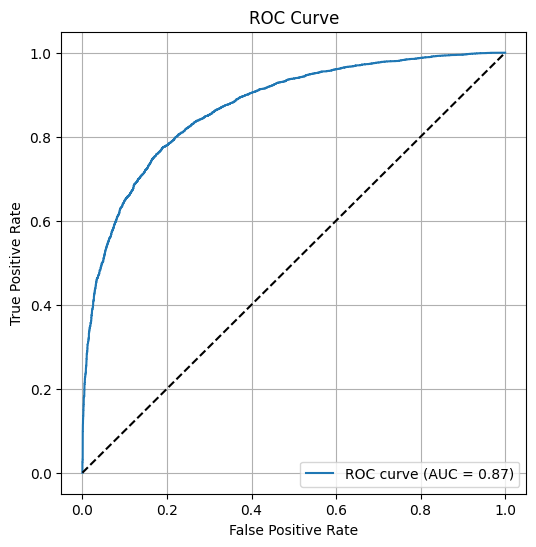

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

TFRECORD_DIR = r"C:\Users\miray\OneDrive\Desktop\Mini Project\tfrecords"
MODEL_PATH = "best_model.h5"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

model = tf.keras.models.load_model(MODEL_PATH)

def parse_example(proto):
    feats = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label':     tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(proto, feats)
    img = tf.io.decode_jpeg(parsed['image_raw'], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    lbl = tf.cast(parsed['label'], tf.float32)
    return img, lbl

def make_dataset(pattern):
    files = tf.io.gfile.glob(pattern)
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTOTUNE)
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = make_dataset(os.path.join(TFRECORD_DIR, "test-*.tfrecord"))

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_bin = (y_pred >= 0.5).astype(int)

# --------- ROC Curve & AUC ---------
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
